In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

In [2]:
os.chdir('../..')

# Features

- Spread
- Avg. volume best offer (same direction)
- Avg. volume best offer (opposite side)
- Midprice
- Avg. trades/min
- Time of the day
- Volatility
- Microprice
- Imbalance
- Volumes and prices of the 5 best levels  
**Warning: average volume at best level in not the same as raw volume**

**Total: 30 features**

In [3]:
snapshots = pd.read_csv('data/truncated_LOB_data_BTC_USD_COINBASE.csv')
snapshots['timestamp'] = pd.to_datetime(snapshots['timestamp'])
snapshots

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,bid_quantity_2,ask_quantity_2,bid_prices_3,ask_prices_3,bid_quantity_3,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,0.077051,0.001200,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.077051,0.001200,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.077051,0.001200,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.077051,0.040000,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,0.077051,0.040000,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,0.072000,0.053628,27967.27,27971.29,0.271732,0.214506,27966.76,27971.32,0.452887,0.028795
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.020000,0.053628,27967.98,27971.29,0.072000,0.214506,27967.27,27971.32,0.271732,0.028795
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.020000,0.053628,27967.98,27971.29,0.072000,0.214506,27967.28,27971.32,0.040000,0.028795
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,0.020000,0.053628,27967.98,27971.28,0.072000,0.040000,27967.28,27971.29,0.040000,0.214506


In [4]:
def convert_timestamp_to_angle(dt_object):
    year, month, day, hour, minute, second = dt_object.year, dt_object.month, dt_object.day, dt_object.hour, dt_object.minute, dt_object.second    
    cos_angle = math.cos((second + minute * 60 + hour * 3600) * (2 * math.pi / 86400))
    sin_angle = math.sin((second + minute * 60 + hour * 3600) * (2 * math.pi / 86400))
    return cos_angle, sin_angle

snapshots['cos_time','sin_time'] = snapshots['timestamp'].apply(convert_timestamp_to_angle)

# LOBSTER data
One actually first use LOBSTER data to reproduce the results from the paper.

In [5]:
# load LOBSTER data
messages = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_5.csv',header=None)
orderbook = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_5.csv',header=None)

messages_columns = ["time","type","id","size","price","direction"]
messages.columns = messages_columns

orderbook_columns = []
for i in range(1,6):
    orderbook_columns.append("ask_price_" + str(i))
    orderbook_columns.append("ask_size_" + str(i))
    orderbook_columns.append("bid_price_" + str(i))
    orderbook_columns.append("bid_size_" + str(i))
orderbook.columns = orderbook_columns

# the orderbook snapshots correspond to snapshots AFTER events
orderbook["time"] = messages["time"]

In [6]:
# trading halt
number_of_trading_halt = (messages["type"] == 7).sum()
assert number_of_trading_halt == 0

In [9]:
# feature engineering
orderbook["midprice"] = (orderbook["ask_price_1"] + orderbook["bid_price_1"]) / 2
orderbook["spread"] = orderbook["ask_price_1"] - orderbook["bid_price_1"]

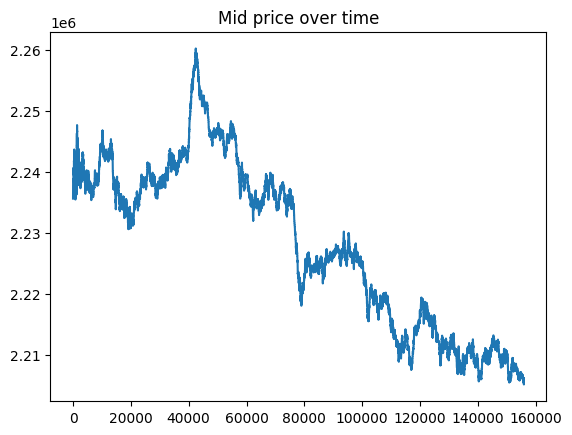

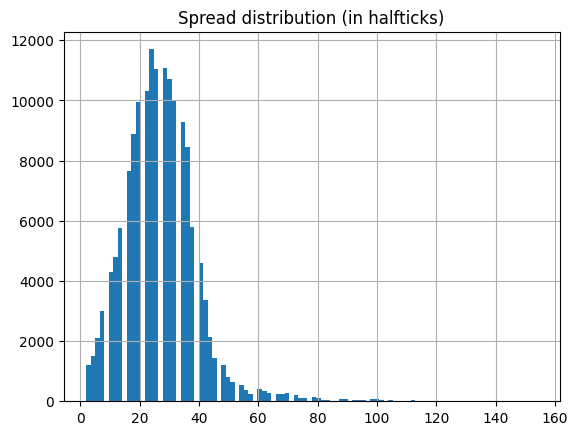

In [10]:
# vizualization
orderbook["midprice"].plot()
plt.title("Mid price over time")
plt.show()

(orderbook["spread"]/50).hist(bins=100)
plt.title("Spread distribution (in halfticks)")
plt.show()

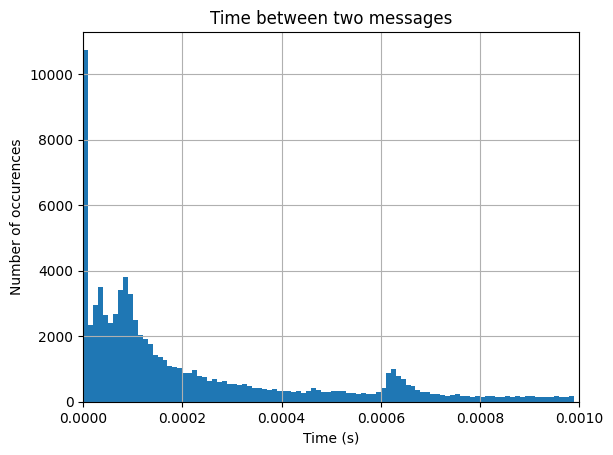

In [11]:
# about snapshots frequency
dt = messages["time"].diff().value_counts().sort_index()
messages["time"].diff().hist(bins=np.arange(0,1e-3,1e-5))
plt.title("Time between two messages")
plt.xlabel("Time (s)")
plt.ylabel("Number of occurences")
plt.xlim(0,1e-3)
plt.show()


In [12]:
def codebar(code):
    pixel_per_bar = 1
    dpi = 100
    heigth = 1

    fig = plt.figure(figsize=(len(code) * pixel_per_bar / dpi, heigth), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # span the whole figure
    ax.set_axis_off()
    ax.imshow(code.reshape(1, -1), cmap='binary', aspect='auto',
            interpolation='nearest')

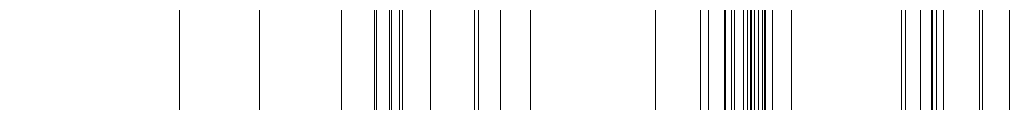

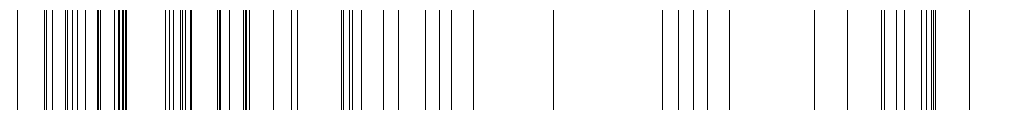

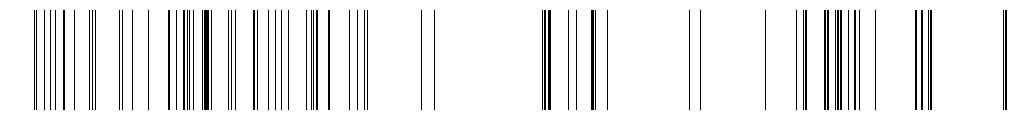

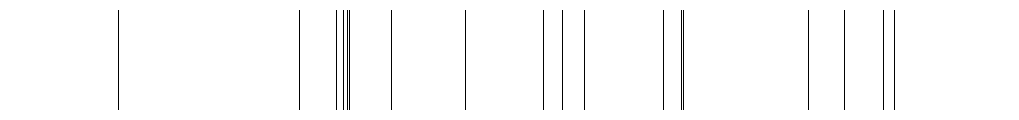

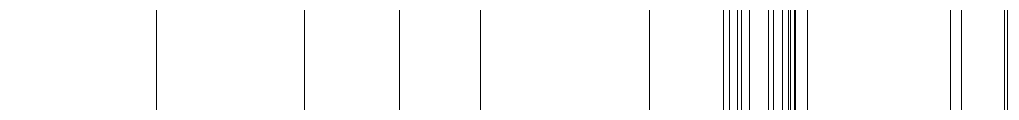

In [13]:
# how are the gaps distributed ?
for idx in range(min(len(messages)//1000,5)):
    codebar((messages["time"].diff().iloc[1:] > 1).iloc[1000*idx:1000*(idx+1)].to_numpy())
    plt.show()

## Reconstruct the queues

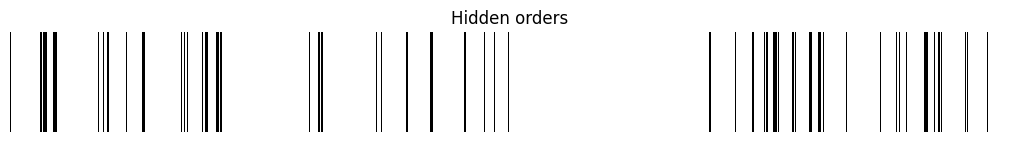

In [14]:
def vizualize(idx_event):
    return messages.iloc[idx_event-3:idx_event+4], orderbook.iloc[idx_event-3:idx_event+4]

codebar(np.array((messages["type"] == 5).iloc[:1000]))
plt.title("Hidden orders")
plt.show()

About the direction:  
-1: Sell limit order  
1: Buy limit order  

Note:  
Execution of a sell (buy) limit order corresponds to a buyer (seller) initiated trade, i.e. Buy (Sell) trade.

In [15]:
def execute_order(queue,time,size):
    """This function executes an order given a queue and a size.
    It returns the new queue and a list of (time submission, lifetime, 1)."""

    # parameters
    # assert len(queue) > 0
    if len(queue) == 0:
        print("Warning: queue is empty and execution is not finished.")
        return queue, []
    
    id_sub,t_sub,size_sub,level_sub = queue[0]
    returns = []
    while size > 0:
        if size_sub <= size:
            queue.pop(0)
            returns.append((id_sub, t_sub, time-t_sub, 1, level_sub))
            size -= size_sub
            if queue == []:
                print("Warning: queue is empty and execution is not finished.")
                size = 0
            else:
                id_sub,t_sub,size_sub,level_sub = queue[0]
        else:
            queue[0] = (id_sub,t_sub,size_sub-size, level_sub)
            returns.append((id_sub, t_sub, time-t_sub, 1, level_sub))
            return queue,returns
    return queue,returns

def update_queues(queues, message, value_to_index):
    """This function updates the queues given a message.
    It returns a list of (time submission, lifetime, 0 if cancelled else 1)."""

    # parameters
    time, order_type, id, size, price, direction, level = list(message)
    order_type = int(order_type)
    price_index = value_to_index[price]

    # submission
    if order_type == 1:
        if queues[direction][price_index] is not None:
            queues[direction][price_index].append((id, time, size, level))
        return None
    # partial cancellation
    elif order_type == 2:
        if queues[direction][price_index] is not None:
            id_list = [elem[0] for elem in queues[direction][price_index]]
            try:
                order_position = id_list.index(id)
                id_sub,t_sub,size_sub,level_sub = queues[direction][price_index][order_position]
                queues[direction][price_index][order_position] = (id_sub,t_sub,size_sub-size,level_sub)
                return [(id_sub, t_sub, time-t_sub, 0, level_sub)]
            except ValueError:
                print("The canceled order is not in the queue.")
                return None      
    # total cancellation
    elif order_type == 3:
        if queues[direction][price_index] is not None:
            id_list = [elem[0] for elem in queues[direction][price_index]]
            try:
                order_position = id_list.index(id)
                id_sub,t_sub,size_sub,level_sub = queues[direction][price_index][order_position]
                queues[direction][price_index].pop(order_position)
                return [(id_sub, t_sub, time-t_sub, 0, level_sub)]
            except ValueError:
                print("The canceled order is not in the queue.")
                return None
    # execution
    elif order_type == 4: # beware of the direction
        if queues[-direction][price_index] is not None:
            queues[-direction][price_index],returns = execute_order(queues[-direction][price_index],time,size)
            return returns
        
    elif order_type == 5:
        if queues[direction][price_index] is not None:
            # print("Current queue is:",queues[direction][price_index])
            # print("Limit order is:",order_type, price, direction)
            # raise KeyError
            pass

def get_level(price,direction,orderbook_at_sub):
    if direction == 1:
        level = int((orderbook_at_sub["bid_price_1"]-price)/100)
    else:
        level = int((price-orderbook_at_sub["ask_price_1"])/100)
    return level

In [16]:
# new dataset
dataset = []

# list of prices that appear during the day
prices = messages["price"].unique() # orderbook[orderbook.columns[::2]].stack().unique()
value_to_index = {value: index for index, value in enumerate(prices)}
queues = {1:[None for i in range(len(prices))],
          (-1):[None for i in range(len(prices))]}

# prime index (price movements allow to prime the queues)
bid_price_1_increase_index = (orderbook["bid_price_1"].diff() > 0.)
bid_price_1_increase_index = bid_price_1_increase_index[bid_price_1_increase_index].index[1:]
ask_price_1_decrease_index = (orderbook["ask_price_1"].diff() < 0.)
ask_price_1_decrease_index = ask_price_1_decrease_index[ask_price_1_decrease_index].index[1:]

for idx,message in messages.iterrows():
    # prime
    price_idx = value_to_index[message["price"]]
    if (idx in bid_price_1_increase_index): # (message["direction"] == 1)
        queues[1][price_idx] = []
    elif (idx in ask_price_1_decrease_index): # (message["direction"] == -1)
        queues[-1][price_idx] = []
    
    # update
    if message["type"] == 1:
        orderbook_at_sub = orderbook.iloc[idx-1]
        level = get_level(message["price"],message["direction"],orderbook_at_sub)
        message["level"] = level
    else:
        message["level"] = None
        
    result = update_queues(queues,message,value_to_index)
    if result is not None:
        dataset += result

The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.
The canceled order is not in the queue.


In [29]:
print("Share of cancelled orders:",round(100*(dataset["cause"]==0).mean(),2),"%")

Share of cancelled orders: 93.84 %


## KM estimate

In [30]:
tick_size = min(orderbook["bid_price_1"]-orderbook["bid_price_2"])

In [31]:
# dataset
columns = ['id_sub','t_sub', 'lifetime', 'cause', 'level']
dataset = pd.DataFrame(dataset, columns=columns)
dataset['level'] = dataset['level'].astype(int)
dataset.to_csv("data/LOBSTER/AMZN_2012-06-21_34200000_57600000_events_5.csv",index=False)

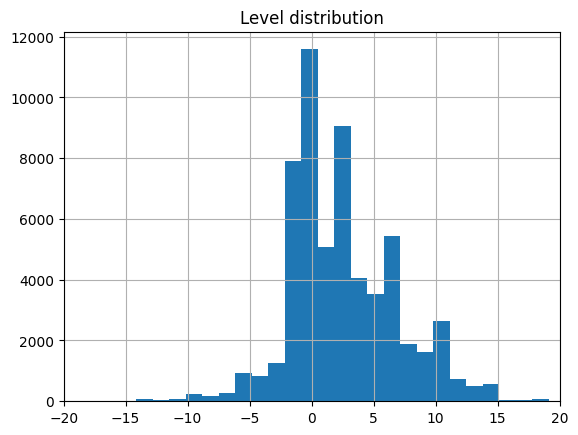

In [32]:
# Level distribution
dataset["level"].hist(bins=100)
plt.title("Level distribution")
plt.xlim(-20,20)
plt.show()

In [33]:
def compute_km_estimate(df):
    "Compute the Kaplan-Meier estimate of the survival function of the lifetime distribution."
    sorted_df = df.sort_values(by='lifetime').reset_index()
    sorted_df['num_survivors'] = len(sorted_df)-sorted_df.index
    sorted_df.set_index('lifetime',inplace=True)
    km_factors = 1-(sorted_df['cause']==1)/sorted_df['num_survivors']
    km_estimate = km_factors.cumprod()
    return km_estimate

Level -1 has 5844 samples.
Level 0 has 11583 samples.
Level 1 has 5093 samples.
Level 2 has 5257 samples.
Level 3 has 3786 samples.
Level 4 has 4048 samples.


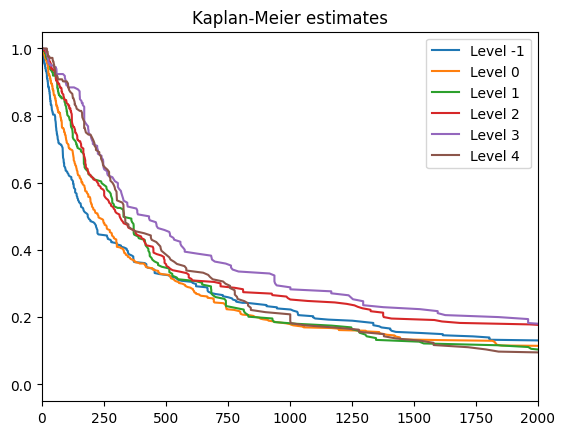

In [34]:
# KM estimates
for level in range(-1,5):
    df = dataset[dataset['level']==level]
    print("Level",level,"has",len(df),"samples.")
    km_estimate = compute_km_estimate(df)
    plt.plot(km_estimate,label='Level '+str(level))
plt.xlim(0,2000)
plt.legend()
plt.title('Kaplan-Meier estimates')
plt.show()